## Notebook to test DimeNet

## Data preparation

In [ ]:
from glob import glob  # noqa: I002

from rdkit import Chem

CHEMBL_100k = glob("../structures/*/conf_00.sdf")[:100000]  # noqa: PTH207

example = CHEMBL_100k[21]

suppl = Chem.SDMolSupplier(example, removeHs=False, sanitize=False)
pos = suppl[0].GetConformer().GetPositions()

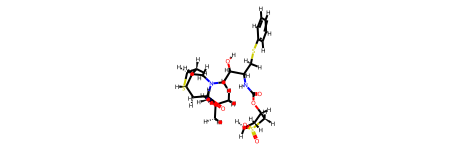

In [6]:
suppl[0]

Run the following:
```sh
pip install torch-sparse  -f https://pytorch-geometric.com/whl/torch-2.0.1+cu117.html
pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.0.1+cu117.html
pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.0.1+cu117.html
```

### Test training via MolBind package

In [ ]:
import torch
from lightning import Trainer
from omegaconf import DictConfig
from torch_geometric.loader import DataLoader as GeometricDataLoader

from molbind.data.components.datasets import StructureDataset
from molbind.models.components.custom_encoders import StructureEncoder
from molbind.models.components.dimenet_lightningmodule import StructureEncoderModule


In [ ]:
config = DictConfig(
    {
        "hidden_channels": 128,
        "out_channels": 1,
        "num_blocks": 6,
        "num_bilinear": 8,
        "num_spherical": 7,
        "num_radial": 6,
        "cutoff": 5.0,
        "envelope_exponent": 5,
        "num_before_skip": 1,
        "num_after_skip": 2,
        "num_output_layers": 3,
    }
)
model = StructureEncoder(config)

In [ ]:
train_files = CHEMBL_100k[: int(len(CHEMBL_100k) * 0.8)]
val_files = CHEMBL_100k[int(len(CHEMBL_100k) * 0.8) :]

In [ ]:
val_dataset = StructureDataset(sdf_file_list=val_files, dataset_mode="encoder")

train_dataset = StructureDataset(sdf_file_list=train_files, dataset_mode="encoder")

train_struct_dataloader = GeometricDataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    prefetch_factor=2,
    num_workers=2,
)

valid_struct_dataloader = GeometricDataLoader(
    dataset=val_dataset,
    batch_size=128,
    shuffle=False,
    drop_last=True,
    prefetch_factor=2,
    num_workers=2,
)

In [ ]:
torch.cuda.empty_cache()
trainer = Trainer(
    max_epochs=100,
    devices=1,
    precision="16-mixed",
    deterministic=True,
    accelerator="cuda",
)

trainer.fit(
    StructureEncoderModule(config),
    train_dataloaders=train_struct_dataloader,
    val_dataloaders=valid_struct_dataloader,
)